# My MINST Adventure

本模組使用 [MNIST](http://yann.lecun.com/exdb/mnist/) 手寫數字資料庫，測試各種機器學習分類演算法以及各種 Python 技巧。


# ★ Importing libraries

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir =  groot_dir + 'training/'
predict_dir = groot_dir + 'predict/'
figure_dir = groot_dir + 'figure/'
covid_dir = groot_dir + 'covid19/'
dataroot_dir = groot_dir

covid_fig = 'covid/'
mnist_fig = 'mnist/'

location = lambda s: 'predict/' if s[0] == 'p' else 'training/' if (s[0] =='t' or s[0] =='d') else 'figure/'
file_at = lambda usage, name: dataroot_dir + location(usage) + name
file_from = lambda usage, name: dataroot_dir + location(usage) + name
myfile_from = lambda usage, name: dataroot_dir + location(usage) + name

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s


TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', groot_dir)

print('\nThis module is amied to explore MNIST dataset...') 
print('\nLibraries and dependenciess imported')
print_local_now()

## ⓷ Show MNIST digit helper 

### Confusion Matrix and ROC Plotter

- [Demystifying ‘Confusion Matrix’ Confusion](https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd) 這篇文章不錯，解釋很清楚，另外一篇[Sarang Narkhede
](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)的文章，手繪插圖做得不錯。若使用 sklearn，下面的程式片段，可以把tn, fp, fn, tp 數字都找出來。


```
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
```

以下是 Wikipedia 的坐標格式

![](https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In [2]:
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib as mpl
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def tf_diag(a):
    b = np.array(a).copy()
    rev_diag = np.diag(np.array(a))[::-1]
    for i, x  in enumerate(rev_diag):
        b[i][i] = x
    return b

def cm_transform(cm):
    newcm = np.zeros(cm.shape)
    for i in range(cm.shape[0]):
        newcm[i] = cm[:,i]
    return newcm.astype(np.int)

def my_plot_confusion_matrix(y_val, y_hat, target_names,
        title='CSP Confusion Matrix',
        figsize = (8, 6),
        cmap=None,
        normalize=True,
        ax = None):
    """
    given the observed and predicted values delivered by a classifier, make 
    a nice plot of the confusion matrix

    Arguments
    ---------
    y_val       : the observed values
    y_hat       : the predictced values
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                see http://matplotlib.org/examples/color/colormaps_reference.html
                plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                If True, plot the proportions
    """

    cm = confusion_matrix(y_val, y_hat)
    cm = tf_diag(cm) if cm.shape[0] == 2 else cm_transform(cm)

    n_classes = cm.shape[0]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    accuracy = accuracy_score(y_val, y_hat)

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams['xtick.labelsize']= 14
    plt.rcParams['ytick.labelsize']= 14
    plt.rcParams['axes.titlesize']= 14

    ax.set_title(title, fontsize = 14)
    fig.colorbar(ScalarMappable(norm=None, cmap=cmap), ax=ax)

    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set(xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=target_names,
        yticklabels=target_names,
        ylabel="Predicted label",
        xlabel="True label")
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.3f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)

    return ax

def generic_plot_roc(y_true, y_prob, figsize = (8, 8), ax = None):

    fpr, tpr, _ = roc_curve(y_true, y_prob )

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    ax.plot(fpr, tpr, c = 'navy', label = 'auc=%4.2f' % auc(fpr, tpr))
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)    
    ax.plot( [0, 1], ls = '-.', lw = 1, color = '#202050', 
        label = 'fpr = tpr', alpha = 0.6)
    ax.legend(loc = 'best', frameon = True , shadow = True, fontsize = 12)
    ax.grid('on', ls = '--', alpha = 0.5)

    plt.ylim(0, 1)
    plt.xlim(0, 1)
    return ax

print('Loading confusion matrix plotter and roc curve plotter...')
print_local_now()

Loading confusion matrix plotter and roc curve plotter...
Local Time: 2020-06-26 09:38:25.448963


### How to display MNIST digits

- show_mnist_digit(): display bitmapped mnist digit
- show_digit_hex(): show hex value of mnist digit
- numpy.random.[randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

In [ ]:
def show_mnist_digit(xdata, ydata, digit_index, add_noise = False, 
    title = None,
    outfile = ''):
    d = xdata[digit_index]
    d = np.reshape(d, (28, 28))
    if add_noise:
        anoise = np.random.randint(0, 100, (28, 28))
        d = d + anoise
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
    
    plt.title( ('mnist index ' if title is None else title) + f'{digit_index:d} = {ydata[digit_index]:d}' , 
        fontsize = 14)
    if (outfile):
        plt.savefig(gfigure(outfile), dpi = 300)
#     plt.show()
    
def show_digit_hex(data, digit_index):
    # if digit_index >= 10000: return
    d = data[digit_index]
    d = np.reshape(d, (28, 28)).astype(np.int)
    # print('begin show digits\n')
    for row in range(0, 28):
        for col in range(0, 28):
            print("%02X " % d[row][col], end="")
        print("") 

def predict_digit_viask(model, images, labels, to_be_checked = None):
        
    if to_be_checked is None:
        to_be_checked = np.random.randint(1, 10000, 1)
        
    d = images[to_be_checked].reshape(1, 28*28)
    y_guess = model.predict(d)

    # print('classifier %s prediction' % model_name)
    print('test set digit index [%d]' % to_be_checked)
    print('answer = %d , predicted = %d\n' % 
        (labels[to_be_checked], y_guess[0]) )
    
    prob_list = model.predict_proba(d)

    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].imshow(images[to_be_checked].reshape(28, 28), 
        cmap=plt.get_cmap('gray_r') )
    ax[0].grid(b = 'on', alpha = 0.5, ls = '--')
    ax[0].set_title('MNIST Test Set: [%d] = %d' \
        % (to_be_checked, labels[to_be_checked]))

    ax[1].bar(np.arange(10), prob_list[0])
#     ax[1].set_aspect(0.1)
    ax[1].set_xticks(np.arange(10))
    ax[1].set_yticks(np.arange(0,1.1,0.1))

    ax[1].grid('on', color = '#eeeeee', ls = '--')
    ax[1].set_title('Class %d Probability %0.3f' % (np.argmax(prob_list[0]), max(prob_list[0])))
    plt.tight_layout()
    output_fig(mnist_fig + 'prediction %d' % to_be_checked)

print('Loading mnist digits plotting helpers')
print_local_now()

In [ ]:
from __future__ import print_function, unicode_literals
import torch, torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn

import statsmodels
import yellowbrick

print('numpy', np.__version__)
print('scipy', scipy.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)
print('sklearn', sklearn.__version__)
print('statsmodels', statsmodels.__version__)
# print('yellowbrick', yellowbrick.__version__)
import sys
print('Python Version', sys.version)

print('\n')
print('PyTorch', torch.__version__)
print('TorchVision',torchvision.__version__)

# ① load idx-coded mnist dataset




檔案格式說明，參考下列連結：

- Yann LeCunn 網站提供 [idx](http://yann.lecun.com/exdb/mnist/) 格式[說明](http://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html)，mlxtend 也提供以 Python 如以 mlxtend 套件[載入資料庫](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)的說明。

- [Kaggle](https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer) 上有 csv 格式的說明

- [MNIST Dataset Python Example Using CNN](https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19)

- [Using MNIST](https://www.python-course.eu/neural_network_mnist.php)

- [np.fromfile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html) API 說明

Yann LeCunn 維護的 MNIST 資料已經下載回來，放在 ～/Google Drive/adventures/mnist/。以下程式將 idx 格式的檔案載入記憶體，以 Pandas DataFrame 格式封裝起來。為了日後使用方便，並將 DataFrame 內容以 Python 內建的 `Pickle` 格式存入本地硬碟。


讀入資料後，分成兩個資料集 `train` & `test`，兩個資料集的 shape 以及資料筆數如下述：

- shape of train_x (60000, 784)
- shape of train_y (60000,)
- shape of test_x (10000, 784)
- shape of test_x (10000,)

## Fetch MNIST dataset

In [ ]:
train_data_file = groot_dir + '/mnist/train-images-idx3-ubyte'
train_label_file = groot_dir + 'mnist/train-labels-idx1-ubyte'
test_data_file = groot_dir + '/mnist/t10k-images-idx3-ubyte'
test_label_file = groot_dir + 'mnist/t10k-labels-idx1-ubyte'

In [ ]:
fetch_gdrive_file(MNIST_TRAIN, 
    os.path.join(groot_dir, 'mnist','train-images-idx3-ubyte' ))
fetch_gdrive_file(MNIST_TRAIN_LABEL, 
    os.path.join(groot_dir, 'mnist','train-labels-idx1-ubyte' ))
fetch_gdrive_file(MNIST_TEST, 
    os.path.join(groot_dir, 'mnist','t10k-images-idx3-ubyte' ))
fetch_gdrive_file(MNIST_TEST_LABEL, 
    os.path.join(groot_dir, 'mnist','t10k-labels-idx1-ubyte' ))

### If you're a die-hard fan of DIY
- [Python GZip](https://docs.python.org/3/library/gzip.html)
- [How to unzip gz file using Python](https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python)

In [ ]:
import gzip
import shutil

file1 = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
file2 = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
file3 = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
file4 = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

fetch_file_via_requests( file4 , groot_dir)

orig_file = os.path.join( groot_dir, 't10k-labels-idx1-ubyte.gz')
uncompress_file = os.path.join(groot_dir, 't10k-labels-idx1-ubyte')

with gzip.open(orig_file, 'rb') as f_in:
    with open(uncompress_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Read dataset and dump pickle  ✔

dump datafram to pickle 時，應該儲存**沒有處理**過（label smoothing, nomalization）的資料。下次取出來使用的時候，依照當時需求，實驗目的，再做必要的 preprocessing or feature engingeering 即可

### read_idx

In [ ]:
import struct, pickle
from scipy.ndimage.interpolation import shift

def read_idx(filename):
    with open(filename,'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        if (dims == 3):
            n = struct.unpack('>I', f.read(4))[0]
            r = struct.unpack('>I', f.read(4))[0]
            c = struct.unpack('>I', f.read(4))[0]
            shape = (n, r, c)
        else:
            n = struct.unpack('>I', f.read(4))[0]
            shape = (n)
#         print('idx shape =', shape)
        return np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dx, dy], cval = 0, mode ='constant')
    return shifted_image.reshape([-1])

### read idx coded files and dump them to pickle

In [ ]:
train_data_file = groot_dir + '/mnist/train-images-idx3-ubyte'
train_label_file = groot_dir + 'mnist/train-labels-idx1-ubyte'
test_data_file = groot_dir + '/mnist/train-images-idx3-ubyte'
test_label_file = groot_dir + 'mnist/t10k-labels-idx1-ubyte'


#
# Read original dataset 
#
raw_train = read_idx(groot_dir  + '/mnist/train-images-idx3-ubyte')    # train_x
raw_train = raw_train.astype(np.float) # set dtype = float
train_data = np.reshape(raw_train, (60000, 28*28))
train_y = read_idx(groot_dir + 'mnist/train-labels-idx1-ubyte')  # train_y

raw_test = read_idx(groot_dir + 'mnist/t10k-images-idx3-ubyte')      # test_x
raw_test = raw_test.astype(np.float)
test_data = np.reshape(raw_test, (10000, 28*28))
test_y = read_idx(groot_dir + 'mnist/t10k-labels-idx1-ubyte')

with open(groot_dir + "/mnist/float_mnist.pkl", "bw") as fh:
    data = (train_data, train_y, test_data, test_y)
    pickle.dump(data, fh)

#
# create noisy dataset
#

noise = np.random.randint(0, 100, (len(train_data), 784))
x_train_noisy = train_data + noise
noise = np.random.randint(0, 100, (len(test_data), 784))
x_test_noisy = test_data + noise

with open(groot_dir + "/mnist/noisy_mnist.pkl", "bw") as fh:
    data = (x_train_noisy, train_y, x_test_noisy, test_y)
    pickle.dump(data, fh)

#
# create augmented dataset
#
# x_train_aug = [image for image in train_data]
# y_train_aug = [image for image in train_y]

# for dx, dy in ((1,0), (-1, 0), (0,1), (0, -1)):
#     for image, label in zip(x_train, y_train):
#         x_train_aug.append(shift_image(image, dx, dy))
#         y_train_aug.append(label) 

# x_train_aug = np.array(x_train_aug)
# y_train_aug = np.array(y_train_aug)

# apickle = os.path.join(groot_dir, 'mnist', 'augmented_mnist.pkl')
# with open(apickle, "bw") as fh:
#     data = (x_train_aug, y_train_aug, test_data, test_y)
#     pickle.dump(data, fh)

print_local_now()

Local Time: 2020-06-14 00:19:39.044760


In [ ]:

# map original pixels into [0.01, 1] by multiplying each pixel by 0.99/255
# and adding 0.01 
#
# 經過實測，label smoothing 是必要的，可以提高辨識率。
#
#                   actualizado el veinticinco de febrero de 2020 

fac = 0.99/255
train_X = train_data * fac + 0.01
test_X = test_data * fac + 0.01

print('shape of train_X', train_X.shape)
print('shape of train_y', train_y.shape)
print('shape of test_X', test_X.shape)
print('shape of test_x', test_y.shape)

print_local_now()

shape of train_X (60000, 784)
shape of train_y (60000,)
shape of test_X (10000, 784)
shape of test_x (10000,)
Local Time: 2020-06-14 00:34:15.980856


### how to add noise

In [ ]:
#
# create noisy dataset
#

noise = np.random.randint(0, 100, (len(train_data), 784))
x_train_noisy = train_data + noise
noise = np.random.randint(0, 100, (len(test_data), 784))
x_test_noisy = test_data + noise

### augmented dataset

In [ ]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dx, dy], cval = 0, mode ='constant')
    return shifted_image.reshape([-1])

## fetch_openml 

- [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html?highlight=fetch_openml#sklearn.datasets.fetch_openml) API

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

X, y = mnist["data"], mnist["target"]

Train_X, Train_y= x[:60000], y[:60000]
test_X, test_y = [60000:], y[60000:]

## Load previously stored pickle for demo purpose

Load the pickled mnist digits into data frames **train_data**, **y_train**, test_data and y_test

In [ ]:
%%time
# from torchvision import datasets, transforms
import pickle
# from torch.utils.data import DataLoader, TensorDataset
# from torch import from_numpy
from datetime import datetime
from dateutil.relativedelta import *
import os

AUGMENTED = False
ADD_NOISE = False
LABEL_SMOOTHING = True
USE_TF = False

pkl_path = os.path.join(groot_dir, 'mnist', '%s_mnist.pkl' % \
    ('augmented' if AUGMENTED else 'float'))

with open(pkl_path, "br") as fh:
    (train_data, y_train, test_data, y_test) = pickle.load(fh)

print('pickled data loaded into memory')

#
# add noise
#
if (ADD_NOISE):
    noise = np.random.randint(0, 100, (len(train_data), 784))
    train_data = train_data + noise
    noise = np.random.randint(0, 100, (len(test_data), 784))
    test_data = test_data + noise

# if USE_TF:
#     print('reshapd for TensorFlow ')
#     x_train = train_data.reshape(train_data.shape[0], 28, 28)
#     x_test = test_data.reshape(test_data.shape[0], 28, 28)
# else:
#     x_train = train_data
#     x_test = test_data

if LABEL_SMOOTHING:
    fac = 0.99/255
    x_train = train_data * fac + 0.01
    x_test = test_data * fac + 0.01
else:
    x_train = train_data
    x_test = test_data
    
print('Augmnted:', AUGMENTED, ', Add-Noise:', 
      ADD_NOISE, ', Label Smoothing:', LABEL_SMOOTHING)
print('shape of train set ',x_train.shape, y_train.shape)
print('shape of test set', x_test.shape, y_test.shape)
print_local_now()

pickled data loaded into memory
Augmnted: False , Add-Noise: False , Label Smoothing: True
shape of train set  (60000, 784) (60000,)
shape of test set (10000, 784) (10000,)
Local Time: 2020-06-14 00:40:19.700706
CPU times: user 259 ms, sys: 524 ms, total: 783 ms
Wall time: 1.26 s


## create figure output directory if necessary

In [ ]:
import os

figure_repo, mnist_figure = 'figure', 'mnist'

mnist_figure_path = os.path.join(groot_dir, figure_repo, mnist_figure)

if not os.path.isdir( mnist_figure_path ):
    os.mkdir(mnist_figure_path)

## Display hand-written digits ✌

隨機（randonly）找20組 0-9 數字，組合成一個 image

CPU times: user 2.76 s, sys: 15.8 ms, total: 2.78 s
Wall time: 2.78 s


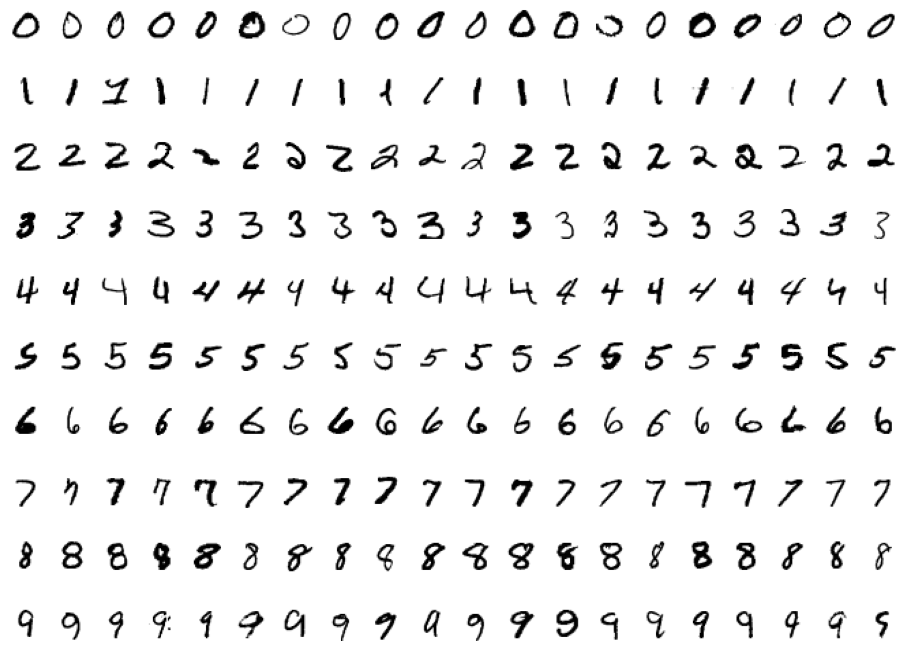

In [ ]:
%%time

chlist = [[], [], [], [], [], [], [], [], [], []] 

for i in range(len(y_train)):
    chlist[y_train[i]].append(i)

d_list = np.random.randint(1, 5000, size = 21) 

figure = plt.figure(figsize=(16, 12))
for i in range(1, 201, 1):
    plt.subplot(10, 20, i)
    plt.axis('off')
    digit_index = chlist[int((i-1)/20) % 10][d_list[((i-1) % 20)]]
    d = train_data[digit_index].reshape(28, 28)
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
# output_fig(mnist_fig + 'mnist digits')

CPU times: user 6.66 s, sys: 37.1 ms, total: 6.69 s
Wall time: 6.7 s


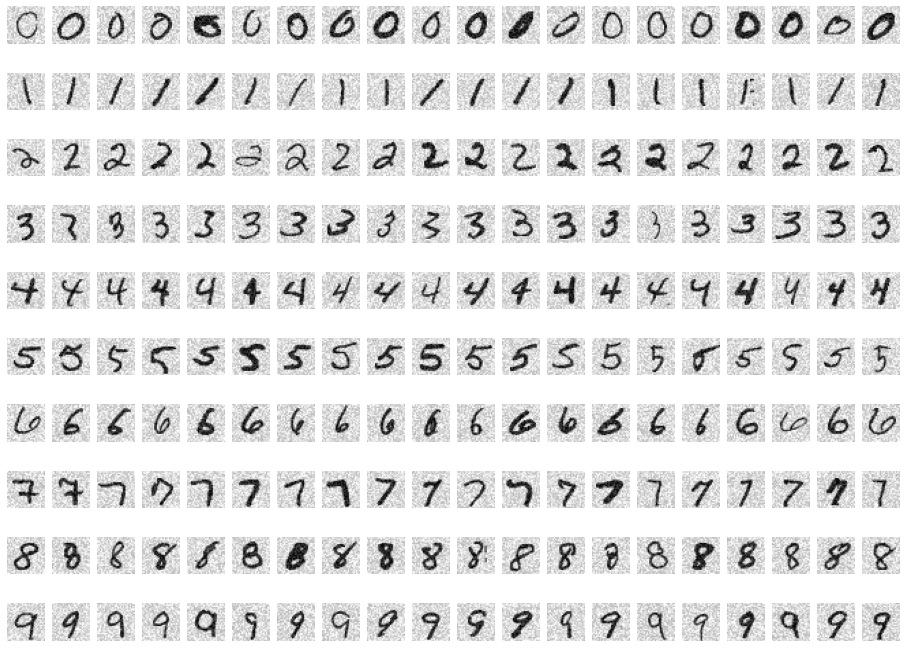

In [ ]:
%%time

chlist = [[], [], [], [], [], [], [], [], [], []] 

for i in range(len(y_train)):
    chlist[y_train[i]].append(i)

d_list = np.random.randint(1, 5000, size = 21) 

figure = plt.figure(figsize=(16,12))
for i in range(1, 201, 1):
    plt.subplot(10, 20, i)
    plt.axis('off')
    digit_index = chlist[int((i-1)/20) % 10][d_list[((i-1) % 20)]]
    d = train_data[digit_index].reshape(28, 28)
    anoise = np.random.randint(0, 100, (28, 28))
    d = d + anoise
# #     d = np.reshape(d, (28, 28) )
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
output_fig(mnist_fig + 'noisy mnist digits')

In [ ]:
num_of_images = 100

char_array = np.random.randint(1, 60000, size = num_of_images)

figure = plt.figure(figsize=(16,12))
for i, digit_index in enumerate(char_array):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    d = train_data[digit_index].reshape(28, 28)

#     d = np.reshape(d, (28, 28) )
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))

output_fig(mnist_fig + 'mnist sample')

In [ ]:
num_of_images = 100

char_array = np.random.randint(1, len(lr_errors), size = num_of_images)

figure = plt.figure(figsize=(16,12))
for i, digit_index in enumerate(char_array):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    d = test_data[lr_errors[digit_index]].reshape(28, 28)

#     d = np.reshape(d, (28, 28) )1 #2
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))

output_fig(mnist_path + 'mnist errs')

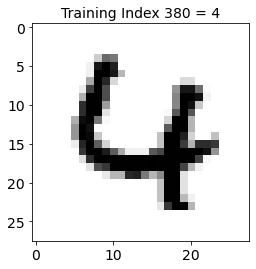

In [60]:
show_mnist_digit(x_train,  y_train, 380, title = 'Training Index ')

In [ ]:
# %%time
# prones = os.path.join(groot_dir, mnist_path, 'errors')


# for i in lr_errors:
#     err_file = prones + '/test %d = %d.png' % (i, y_test[i])
#     d = test_data[i]
#     d = np.reshape(d, (28, 28))
#     plt.imshow(d, cmap=plt.get_cmap('gray_r'))  
#     plt.title( f'Test Index {i:d} = {y_test[i]:d}' , 
#         fontsize = 14)
#     plt.savefig(err_file, dpi = 300)
# print_now()

# ② scikit-learn and MNIST

## ★ Load Pickled MNIST Data

In [5]:
%%time
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, TensorDataset
# from torch import from_numpy
import pickle
from datetime import datetime
from dateutil.relativedelta import *
import os

AUGMENTED = False
ADD_NOISE = False
LABEL_SMOOTHING = True
USE_TF = False

pkl_path = os.path.join(groot_dir, 'mnist', '%s_mnist.pkl' % \
    ('augmented' if AUGMENTED else 'float'))

with open(pkl_path, "br") as fh:
    (train_data, y_train, test_data, y_test) = pickle.load(fh)

# train_data = np.array(data[0])
# test_data = np.array(data[1])
# y_train = np.array(data[2])
# y_test = np.array(data[3])
print('SKLEARN: pickled data loaded into memory')

# #
# # add noise
# #
if (ADD_NOISE):
    noise = np.random.randint(0, 100, (len(train_data), 784))
    train_data = train_data + noise
    noise = np.random.randint(0, 100, (len(test_data), 784))
    test_data = test_data + noise

if USE_TF:
    print('reshapd for TensorFlow ')
    x_train = train_data.reshape(train_data.shape[0], 28, 28)
    x_test = test_data.reshape(test_data.shape[0], 28, 28)
else:
    x_train = train_data
    x_test = test_data

if LABEL_SMOOTHING:
    fac = 0.99/255
    x_train = x_train * fac + 0.01
    x_test = x_test * fac + 0.01

print('Augmnted:', AUGMENTED, ', Add-Noise:', 
      ADD_NOISE, ', Label Smoothing:', LABEL_SMOOTHING)
print('shape of train set ',x_train.shape, y_train.shape)
print('shape of test set', x_test.shape, y_test.shape)
print('\n')
print_local_now()


SKLEARN: pickled data loaded into memory
Augmnted: False , Add-Noise: False , Label Smoothing: True
shape of train set  (60000, 784) (60000,)
shape of test set (10000, 784) (10000,)


Local Time: 2020-06-14 13:02:26.670965
CPU times: user 210 ms, sys: 1.48 s, total: 1.69 s
Wall time: 2.07 s


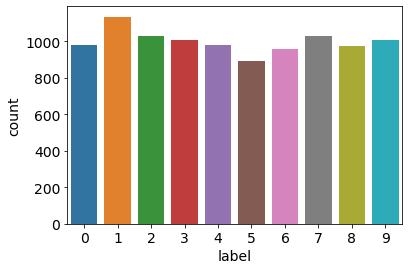

In [59]:
cnt = pd.DataFrame()
cnt['label'] = y_test
ax = sns.countplot(x="label", data=cnt)

## Binary Classification
- [SGDClassfier: regularized linear models with stochastic gradient descent (SGD) learning](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Cross Validation Score (cross_val_score)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score)
- [sklearn.metrics.plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html?highlight=plot_confusion_matrix#sklearn.metrics.plot_confusion_matrix)

In [ ]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [ ]:
type(y_train_9)

In [ ]:
y_train_9[:10]

In [15]:
from sklearn.linear_model import SGDClassifier

binary_clf = SGDClassifier(max_iter = 1000, tol=1e-3, random_state = 42)
binary_clf.fit(x_train, y_train_9)

our_prediction = binary_clf.predict([x_test[0]])
print(y_test[0], our_prediction)


7 [False]


In [47]:
from sklearn.linear_model import SGDClassifier

binary_clf = SGDClassifier(max_iter = 1000, tol=1e-3, random_state = 42)
binary_clf.fit(x_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

y_hat_binary_clf = binary_clf.predict(x_test)

rep = classification_report(y_test_9, y_hat_binary_clf)

print(rep)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      8991
        True       0.92      0.72      0.81      1009

    accuracy                           0.97     10000
   macro avg       0.95      0.86      0.90     10000
weighted avg       0.96      0.97      0.96     10000



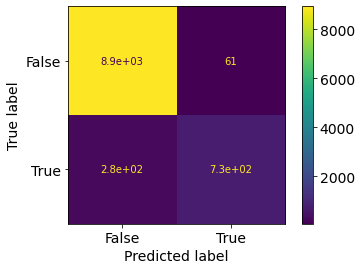

In [31]:
from sklearn.metrics import plot_confusion_matrix

sklearn.metrics.plot_confusion_matrix(binary_clf, x_test, y_test_9)

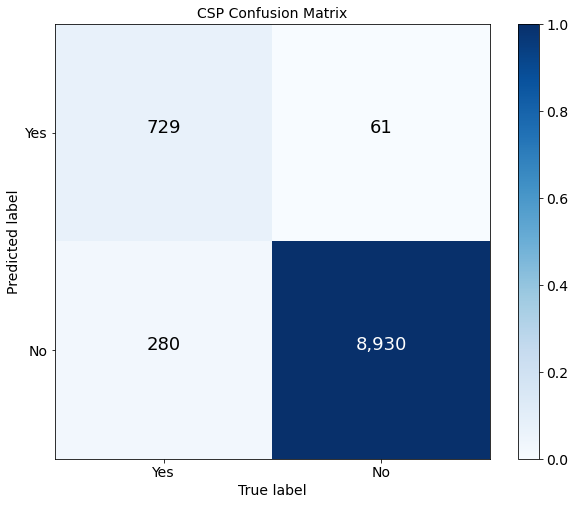

In [50]:
my_plot_confusion_matrix(y_test_9, y_hat_binary_clf, ['Yes', 'No'], 
    normalize = False , 
    figsize = (10, 8))

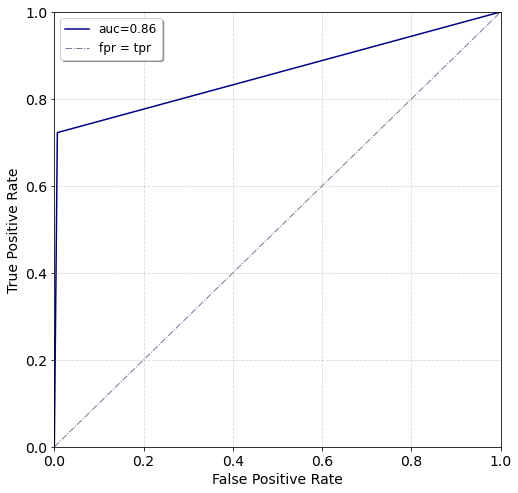

In [41]:
generic_plot_roc(y_test_9, y_hat_binary_clf)

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd = SGDClassifier(max_iter = 1000, tol=1e-3, random_state = 42)
scores = cross_val_score(sgd, x_train, y_train_9, cv = 5, scoring='accuracy')
print(scores)

[0.96675    0.96216667 0.96058333 0.96       0.96491667]


## Logistic Regression

- [sklearn: Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



-----------------------------
trainin set score : 0.9382
test set score    : 0.9262
------------------------------

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

2020-06-14 13:03:37.819315
CPU times: user 1min 52s, sys: 18.3 s, total: 2min 10s
Wall time: 1min 6s


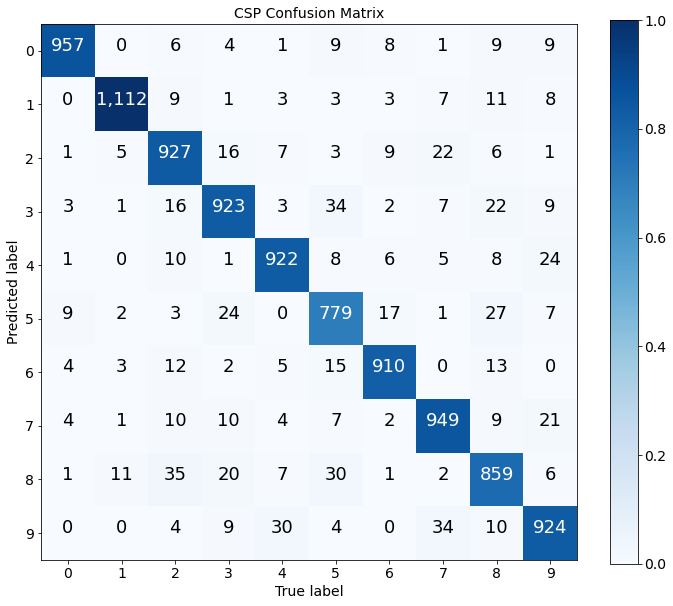

In [6]:
%%time

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

lr = LogisticRegression( max_iter = 200)
lr.fit(x_train, y_train)
y_hat_lr = lr.predict(x_test)

print('\n-----------------------------')
print('trainin set score : %.4f' % lr.score(x_train, y_train))
print('test set score    : %.4f' % lr.score(x_test, y_test))
print('------------------------------')

classes = ['%d' % i for i in range(10)]

rep = classification_report(y_test, y_hat_lr)

print('\nLogistc Regression Classifier' + ' (Data with Noise)' if ADD_NOISE else '')
print(rep) 

# y_prob = lr.predict_proba(x_test)

my_plot_confusion_matrix(y_test, y_hat_lr, classes, normalize=False, 
    figsize = (12, 10))

print_now()

In [ ]:
plot_confusion_matrix(y_test, y_hat_lr, classes, normalize=False, 
    figsize = (12, 10))

output_fig(mnist_fig + 'logistic reg - cm')

test set digit index [9811]
answer = 2 , predicted = 8



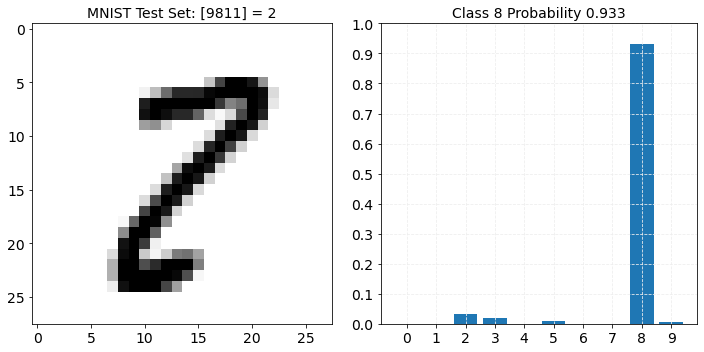

In [ ]:
predict_digit_viask(lr, x_test, y_test, 9811)

In [ ]:
lr_errs = []

for i in range(len(y_test)):
    if y_test[i] != y_hat_lr[i]:
        lr_errs.append(i)

print(len(lr_errs))
# print(lr_errs)

730


In [ ]:
num_of_images = 100

char_array = np.random.randint(1, len(lr_errs), size = num_of_images)

figure = plt.figure(figsize=(12,10))
for i, digit_index in enumerate(char_array):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    d = test_data[lr_errs[digit_index]].reshape(28, 28)

#     d = np.reshape(d, (28, 28) )1 #2
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))

# output_fig(mnist_fig + 'erros - logistic regression')

### YellowBrick ClassificationReport

- [YellowBrick](https://www.scikit-yb.org/en/latest/quickstart.html) [ClassificationReport](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) API



In [ ]:
!pip3 install --upgrade yellowbrick

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


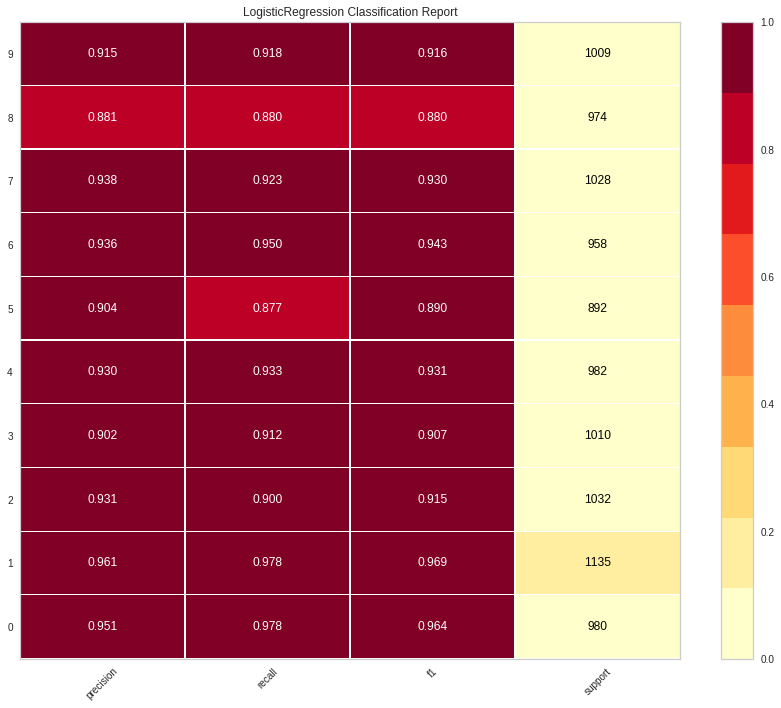

CPU times: user 55.8 s, sys: 8.45 s, total: 1min 4s
Wall time: 33 s


<Figure size 576x396 with 0 Axes>

In [ ]:
%%time

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

digits = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9' ]

plt.figure(figsize=(12,10))
visualizer = ClassificationReport(model, 
    classes=digits, support=True)
visualizer.fit(x_train, y_train)         # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

output_fig(mnist_fig + 'yellowbrick - logistic')

### mlxtend plot_confusion_matrix

- mlxtend [plot_confusion_matrix](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/) user guide

(Google Colab 提供的版本太舊，需要自行安裝最新版)

In [ ]:
!pip3 install --upgrade mlxtend

#### same as sklearn, but more sphiscated

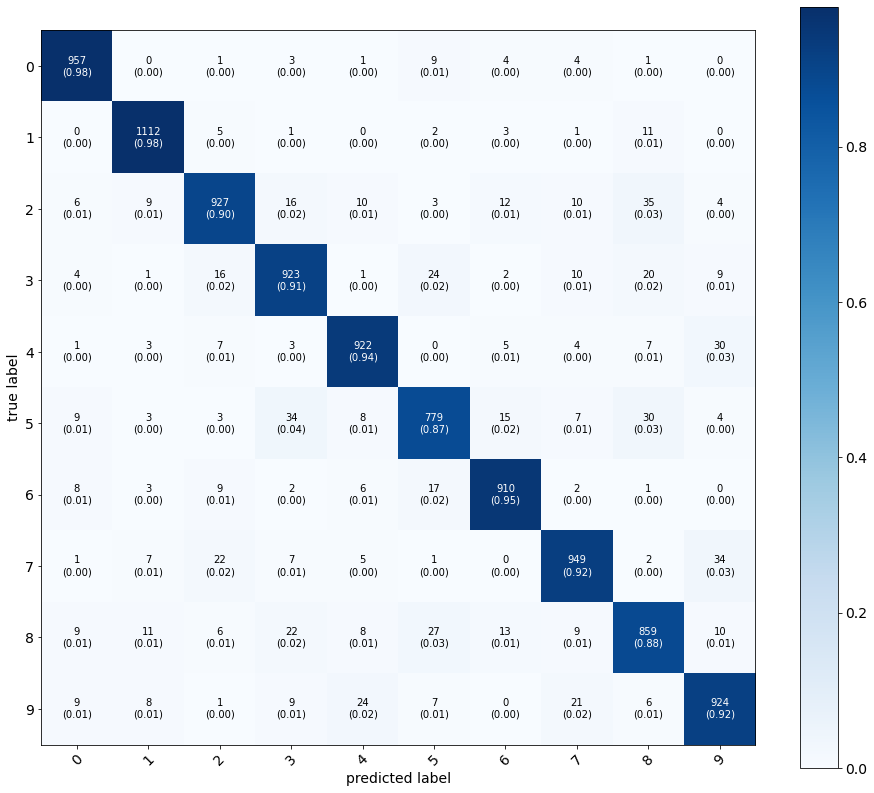

In [7]:
# %%time

# # http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# mlx_cm = cm_transform(confusion_matrix(y_test, y_hat_lr))

mlx_cm = confusion_matrix(y_test, y_hat_lr)

digits = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9' ]

fig, ax = plot_cm3(conf_mat = mlx_cm, class_names = digits, show_normed=True,
    colorbar = True, figsize = (16, 14))
# ax.set_xlabel('True Classes')
# ax.set_ylabel('Predicted Classes')

#### my way

Text(0, 0.5, 'Predicted Classes')

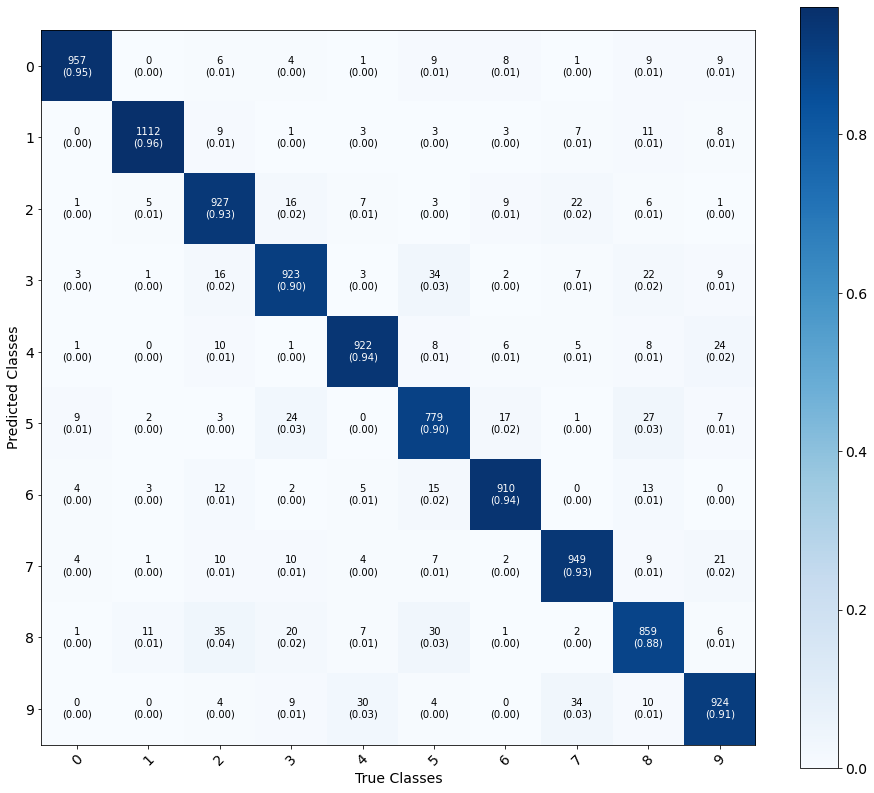

In [ ]:
# %%time

# # http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

mlx_cm = cm_transform(confusion_matrix(y_test, y_hat_lr))

digits = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9' ]


fig, ax = plot_cm3(conf_mat=mlx_cm, class_names = digits, show_normed=True,
    colorbar = True, figsize = (16, 14))
ax.set_xlabel('True Classes')
ax.set_ylabel('Predicted Classes')

In [ ]:
# import pickle

# errs = []

# for i in range(len(test_y)):
#     if test_y[i] != y_hat[i]:
#         errs.append(i)

# import pickle

# with open(groot_dir + "/mnist/errors.pkl", "bw") as fh:
#     data = (errs)
#     pickle.dump(data, fh)

# print(len(errs))
# print(errs[:10])

## k-Nearest Neighbor

In [ ]:
%%time

import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(algorithm = 'auto')
  
knn.fit(x_train, y_train)
y_hat_knn = knn.predict( x_test)

print('-----------------------------')
print('trainin set score: %f' % knn.score(x_train, y_train))
print('test set score: %f' %  knn.score(x_test, y_test))
print('----------------------------')

# rep = classification_report(test_y, y_hat_knn)
# print('\nreport\n', rep)
print('\nexecuted on ', str(datetime.datetime.now()))

-----------------------------
trainin set score: 0.981917
test set score: 0.968800
----------------------------

executed on  2020-05-09 10:43:21.801734
CPU times: user 1h 22min 33s, sys: 6.29 s, total: 1h 22min 39s
Wall time: 1h 23min 8s



              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.95      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



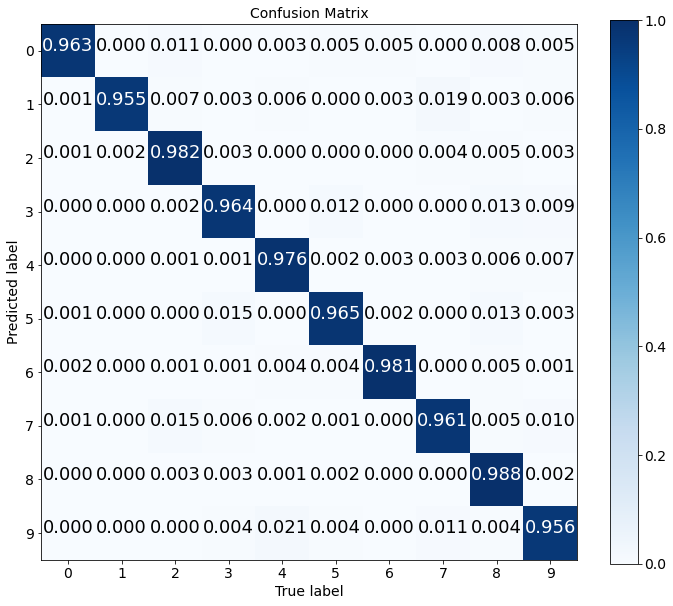

In [ ]:
from sklearn.metrics import  classification_report

classes = ['%d' % i for i in range(10)]

rep = classification_report(y_test, y_hat_knn)

print('\nkNN Classifier' + ' (Data with Noise)' if ADD_NOISE else '')

print(rep) 

plot_confusion_matrix(y_test, y_hat_knn, classes, normalize = False, 
    figsize = (12, 10))

output_fig(mnist_path + 'knn cm normalized')

## Multi Layer Perceptron

In [ ]:
%%time

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(hidden_layer_sizes = (128,),
                    max_iter = 100,
                    activation = 'tanh',
                    solver = 'adam', 
                    tol=1e-4,
                    random_state = 0,
                    learning_rate_init = 0.005,
                    shuffle = True,
                    verbose = False,
                    learning_rate = 'adaptive')
mlp.fit(x_train, y_train)
y_hat_mlp = mlp.predict(x_test)

print('-----------------------------')
print('trainin set score: %f' % mlp.score(x_train, y_train))
print('test set score: %f' %  mlp.score(x_test, y_test))
print('-----------------------------')

rep = classification_report(y_test, y_hat_mlp)

print('\nMulti Layer Perceptorn Classifier' + ' (Data with Noise)' if ADD_NOISE else '')
print(rep) 
print_now()

-----------------------------
trainin set score: 0.992267
test set score: 0.970500
-----------------------------

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.95      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

2020-06-14 01:15:46.245681
CPU times: user 2min 30s, sys: 56.8 s, total: 3min 27s
Wall time: 1min 45s



              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.95      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



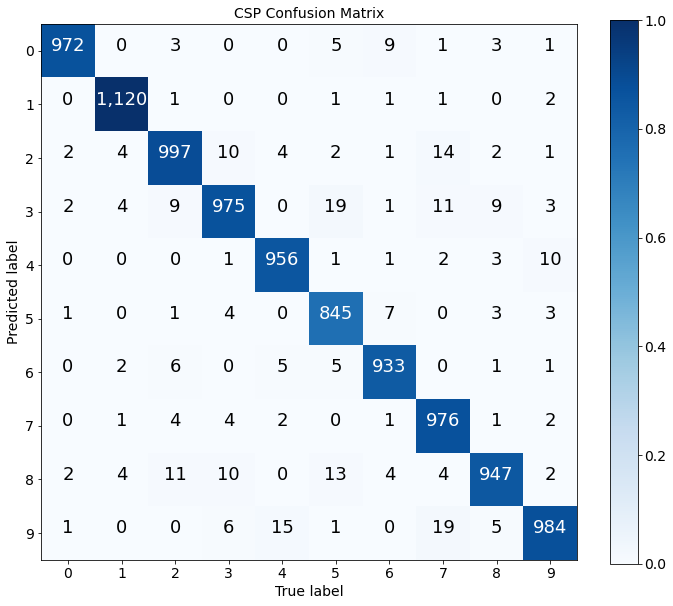

In [ ]:
from sklearn.metrics import  classification_report

rep = classification_report(y_test, y_hat_mlp)

print('\nMulti Layer Perceptorn Classifier' + ' (Data with Noise)' if ADD_NOISE else '')

print(rep) 

plot_confusion_matrix(y_test, y_hat_mlp, classes, normalize=False, 
    figsize = (12, 10))

output_fig(mnist_fig + 'mlp cm')

test set digit index [2022]
answer = 4 , predicted = 4



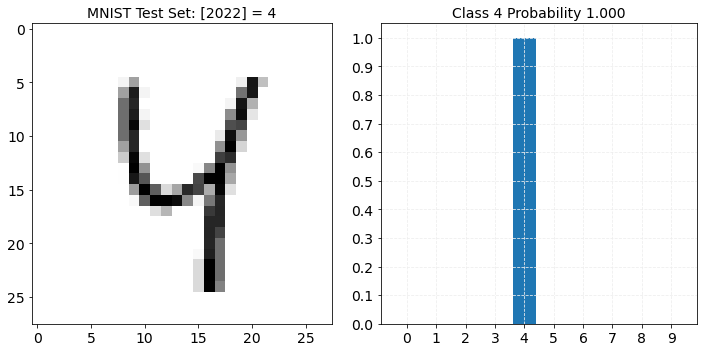

In [ ]:
# 9986 is a good sample
predict_digit_viask(mlp, x_test, y_test, 9986)